In [2]:
import requests
import json
import re
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
# Disable chardet debug messages
import logging
logging.getLogger().setLevel(logging.WARNING)

In [164]:
class MovieMetadata:
    def __init__(self, film_url_short):
        self.film_url_short = film_url_short
        self.headers = {
                'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.163 Safari/537.36',
                'referer': 'https://google.com',
            }
        self.url = 'https://letterboxd.com{}'.format(film_url_short)
        self.soup = self.get_soup()

    def get_soup(self):
        r = requests.get(self.url, headers=self.headers)
        soup = BeautifulSoup(r.content, 'html.parser')
        return soup

    def get_header_desc(self):
        # header  + desc
        header_section = self.soup.find('section', id='featured-film-header')
        title = header_section.find('h1').text.strip() if header_section.find('h1') else None
        year = header_section.find('small').text.strip() if header_section.find('small') else None
        director = header_section.find('span').text.strip() if header_section.find('span') else None

        desc = soup.find('div', class_='review body-text -prose -hero prettify')
        desc = desc.find('div').text.strip() if desc else None

        return title, year, director, desc

    def get_cast(self):
        cast = self.soup.find('div', class_='cast-list text-sluglist')
        if cast != None:
            cast = cast.find_all('a', class_='text-slug tooltip')
            cast = [ppl.text.strip() for ppl in cast]
        else:
            cast = None
        return cast

    def get_crew(self):
        crew_div = self.soup.find('div', id='tab-crew')
        if crew_div != None:
            crew_dic, current_key = {}, None
            for child in crew_div.children:
                if child.name == 'h3':
                    current_key = child.find('span', class_='crewrole -full').text.strip()
                    crew_dic[current_key] = []
                elif child.name == 'div' and child.has_attr('class') and 'text-sluglist' in child['class']:
                    names = [a.text.strip() for a in child.find_all('a', class_='text-slug')]
                    crew_dic[current_key].extend(names)
        else:
            crew_dic = None
        return crew_dic

    def get_details(self):
        details_div = self.soup.find('div', id='tab-details')
        if details_div != None:
            details_dic, current_key = {}, None
            for child in details_div.children:
                if child.name == 'h3':
                    current_key = child.find('span').text.strip()
                    details_dic[current_key] = []
                elif child.name == 'div' and child.has_attr('class') and 'text-sluglist' in child['class']:
                    names = [a.text.strip() for a in child.find_all('a', class_='text-slug')]
                    details_dic[current_key].extend(names)
                elif child.name == 'div' and child.has_attr('class') and 'text-indentedlist' in child['class']:
                    names = [a.text.strip() for a in child.find_all('p')]
                    details_dic[current_key].extend(names)
        else:
            details_dic = None
        return details_dic

    def get_genres(self):
        genres_div = self.soup.find('div', id='tab-genres')
        if genres_div != None:
            genres_dic, current_key = {}, None
            for child in genres_div.children:
                if child.name == 'h3':
                    current_key = child.find('span').text.strip()
                    genres_dic[current_key] = []
                elif child.name == 'div' and child.has_attr('class') and 'text-sluglist' in child['class']:
                    names = [a.text.strip() for a in child.find_all('a', class_='text-slug')]
                    genres_dic[current_key].extend(names)
        else:
            genres_dic = None
        return genres_dic

    def get_footer(self):
        footer = self.soup.find('p', class_='text-link text-footer')
        run_time = footer.text.strip().split('\xa0')[0] # in minutes
        imdb = footer.find('a', attrs={"data-track-action": "IMDb"})
        tmdb = footer.find('a', attrs={"data-track-action": "TMDb"})
        imdb = imdb['href'].split('/')[4] if imdb else None
        tmdb = tmdb['href'].split('/')[4] if tmdb else None
        return run_time, imdb, tmdb

    def get_stats(self):
        movie = self.url.split('/')[-2]
        r = requests.get(f'https://letterboxd.com/esi/film/{movie}/stats/', headers=self.headers)
        soup = BeautifulSoup(r.content, 'lxml')

        watched_by = soup.find('a', {'class': 'has-icon icon-watched icon-16 tooltip'})
        listed_by = soup.find('a', {'class': 'has-icon icon-list icon-16 tooltip'})
        liked_by = soup.find('a', {'class': 'has-icon icon-like icon-liked icon-16 tooltip'})

        watched_by = watched_by.text if watched_by else None
        listed_by = listed_by.text if listed_by else None
        liked_by = liked_by.text if liked_by else None

        return watched_by, listed_by, liked_by

    def get_rate(self):
        url = 'https://letterboxd.com//csi{}rating-histogram/'.format(self.film_url_short)
        r = requests.get(url, headers=self.headers)
        soup = BeautifulSoup(r.content, 'html.parser')
        if soup.find('a', {'class': 'tooltip display-rating -highlight'}):
            ratings = soup.find('a', {'class': 'tooltip display-rating -highlight'})
            if ratings:
                ratings = ratings['title']
                rating = ratings.split(' ')[3]
                rated_by = ratings.split(' ')[6].split('\xa0')[0]
            else: rating, rated_by = None, None
        else:
            rating, rated_by = None, None
        return rating, rated_by

    def get_poster_link(self):
        element = self.soup.find('script', {'type' : 'application/ld+json'})
        if element:
            element = element.text.strip()
            poster_link = re.search(r'"image":"([^"]+)"', element)
            if poster_link:
                poster_link = poster_link.group(1)
            else:
                poster_link = None
        else:
            poster_link = None
        return poster_link

    def combine_all(self):
        title, year, director, desc = self.get_header_desc()
        cast, crew_dic = self.get_cast(), self.get_crew()
        details_dic, genres_dic = self.get_details(), self.get_genres()
        run_time, imdb_id, tmdb_id = self.get_footer()
        watched_by, listed_by, liked_by = self.get_stats()
        rating, rated_by = self.get_rate()
        poster_link = self.get_poster_link()

        def convert_to_number(value):
            if value != None:
                try:
                    number = float(value)
                    return number
                except ValueError:
                    return None
            else:
                return None

        meta_dic = {
            'title': title,
            'year': convert_to_number(year),
            'director': director,
            'desc': desc,
            'cast': cast,
            **crew_dic,
            **details_dic,
            **genres_dic,
            'runtime': convert_to_number(run_time),
            'imdb_id': imdb_id,
            'tmdb_id': tmdb_id,
            'watched_by': watched_by,
            'listed_by': listed_by,
            'liked_by': liked_by,
            'rating': convert_to_number(rating),
            'rated_by': convert_to_number(rated_by),
            'poster': poster_link
        }
        return meta_dic

In [161]:
kr_film = pd.read_pickle('kr_film.pkl')
kr_film.shape

(11632, 2)

In [166]:
%%time
pbar = tqdm(range(0, len(kr_film)))
meta_film_dic = {}
for i in pbar:
    pbar.set_description(f'Scraping movie {i} of {len(kr_film)} pages')
    movie = kr_film['film'][i]
    meta_film_dic[movie.split('/')[2]] = MovieMetadata(movie).get_rate()

Scraping movie 899 of 11632 pages:   8%|▊         | 899/11632 [09:05<1:48:30,  1.65it/s]


KeyboardInterrupt: ignored

In [168]:
!pip install pandarallel -qq

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 3.3 MB/s eta 0:00:00


In [169]:
%%time
from pandarallel import pandarallel
pandarallel.initialize(use_memory_fs=False)
def scrape_movie_rate(movie):
    movie_id = movie.split('/')[2]
    metadata = MovieMetadata(movie)
    rate = metadata.get_rate()
    return movie_id, rate
kr_film['meta'] = kr_film['film'].parallel_apply(scrape_movie_rate)
meta_film_dic = {movie_id: rate for movie_id, rate in kr_film['meta']}

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


Process ForkPoolWorker-2:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/usr/local/lib/python3.10/dist-packages/pandarallel/core.py", line 158, in __call__
    results = self.work_function(
  File "/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py", line 26, in work
    return data.apply(
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/series.py", line 4771, in apply
    return SeriesApply(self, func, convert_dtype, args, kwargs).apply()
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/appl

KeyboardInterrupt: ignored

  File "/usr/lib/python3.10/http/client.py", line 318, in begin
    version, status, reason = self._read_status()
  File "/usr/lib/python3.10/http/client.py", line 279, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.10/ssl.py", line 1274, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/lib/python3.10/ssl.py", line 1130, in read
    return self._sslobj.read(len, buffer)
KeyboardInterrupt


In [147]:
meta = MovieMetadata('/film/fight-for-justice/').combine_all()
meta = pd.DataFrame.from_dict(meta, orient='index')
meta

0
title                                              Fight for Justice
year                                                            1919
director                                                  Kim Do-san
desc               All unemployed, Ki-taek's family takes peculia...
cast               [Kim Do-san, Gyeonghwan Lee, Yeongdeok Kim, Wo...
Director                                                [Kim Do-san]
Producer                                             [Seungpil Park]
Writer                                                  [Kim Do-san]
Original Writer                                 [Miyagawa Sounosuke]
Editor                                                  [Cheon Kung]
Cinematography                                          [Cheon Kung]
Studio                                                         [단성사]
Country                                                [South Korea]
Language                                                    [Korean]
Alternative Title                                    [Uilijeog guto]
Genre                                                       [action]
runtime            More at\n\t\t\t\t\t\tIMDb\nTMDb\n Report this ...
imdb_id                                                   tt13937540
tmdb_id                                                       415956
watched_by                                                         2
listed_by                                                         14
liked_by                                                           0
rating                                                          None
rated_by                                                        None
poster                                                          None

# OLD

In [ ]:
base_url = "https://letterboxd.com/members/popular/this/week/page/{}/"
# can be change to this/month, this/year, or just popular/ -> all time,

total_pages = 128
pbar = tqdm(range(1, total_pages+1))
for page in pbar:
    pbar.set_description(f"Scraping page {page} of {total_pages} of top users")

    r = requests.get(base_url.format(page))
    soup = BeautifulSoup(r.text, "html.parser")
    table = soup.find("table", attrs={"class": "person-table"})
    rows = table.findAll("td", attrs={"class": "table-person"})

    update_operations = []
    for row in rows:
        link = row.find("a")["href"]
        username = link.strip('/')
        display_name = row.find("a", attrs={"class": "name"}).text.strip()
        num_reviews = int(row.find("small").find("a").text.replace('\xa0', ' ').split()[0].replace(',', ''))

        user = {
            "username": username,
            "display_name": display_name,
            "num_reviews": num_reviews
        }

        update_operations.append(
            user
        )

Scraping page 128 of 128 of top users: 100%|██████████| 128/128 [03:04<00:00,  1.44s/it]


In [ ]:
update_operations[0]

{'username': 'saiii', 'display_name': 'saiii', 'num_reviews': 80}

In [ ]:
movie_review_url = 'https://letterboxd.com/film/infernal-affairs/reviews/by/activity/page/1/'
r = requests.get(movie_review_url.format(page))
soup1 = BeautifulSoup(r.text, "lxml")
ratings = soup1.find_all('p',attrs={'class':'attribution'})
rats = []
for i in ratings:
  rating = i.text.strip().split(' ')[0]
  rats.append(rating)
rats

['★★★★',
 '★★★★★',
 '★★★★½',
 '★★★★',
 '★★★½',
 'Watched',
 '★★★★',
 '★★★★★',
 '★★★★½',
 '★★★★',
 '★★★★',
 '★★★★']

In [ ]:
movie_review_url = 'https://letterboxd.com/film/infernal-affairs/reviews/by/activity/page/{}/'
total_pages = 100
pbar = tqdm(range(1, total_pages+1))

rats = []

for page in pbar:
    pbar.set_description(f"Scraping page {page} of {total_pages} of popular reviews")

    r = requests.get(movie_review_url.format(page))
    soup1 = BeautifulSoup(r.text, "lxml")
    table = soup1.find_all('p',attrs={'class':'attribution'})

    for i in range(len(table)):
      rating = table[i].text.strip().split(' ')[0]
      rats.append(rating)

len(rating)

Scraping page 100 of 100 of popular reviews: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


5

In [ ]:
len(rats)

1200

In [ ]:
movie_review_url = 'https://letterboxd.com/film/infernal-affairs/reviews/by/activity/page/{}/'
total_pages = 100
pbar = tqdm(range(1, total_pages+1))

full_reviews = []

for page in pbar:
    pbar.set_description(f"Scraping page {page} of {total_pages} of popular reviews")

    r = requests.get(movie_review_url.format(page))
    soup1 = BeautifulSoup(r.text, "html.parser")
    table = soup1.find_all("a", attrs={"class": "has-icon icon-comment icon-16 comment-count"})

    for i in range(len(table)):
      full_text_link = table[i]['href'].strip()
      full_text_link = 'https://letterboxd.com'+ full_text_link
      r1 = requests.get(full_text_link)
      soup2 = BeautifulSoup(r1.text, "html.parser")
      full_review = soup2.find('div', attrs={'class':"review body-text -prose -hero -loose"}).text.strip()
      full_reviews.append(full_review)

len(full_reviews)

Scraping page 100 of 100 of popular reviews: 100%|██████████| 100/100 [04:30<00:00,  2.70s/it]


272

In [ ]:
review_url = 'https://letterboxd.com/lyvie/films/reviews/'
r = requests.get(review_url.format(page))
soup1 = BeautifulSoup(r.text, "html.parser")

page = soup1.find_all('li', attrs={'class':'paginate-page'})
page_num = int(page[-1].text.strip())
pbar = tqdm(range(1, page_num+1))
#pbar = tqdm(range(1,5))

dict1 = {'title':[],'year':[],'user_rating':[],'watched_date':[],'review':[]}
title_for_url = []

for page in pbar:
    pbar.set_description(f"Scraping page {page} of {page_num} of this user")

    table = soup1.find_all("div", attrs={"class": "film-detail-content"})

    for i in range(len(table)):
      title_link = table[i].find('a')['href'].strip()
      title_for_url.append(title_link.split('/')[3])

      title = table[i].find("a",{"href":title_link}).text.strip()
      dict1['title'].append(title)

      year = table[i].find("small", attrs={"class": "metadata"}).text.strip()
      dict1['year'].append(year)

      rating = table[i].find('p',attrs={'class':'attribution'}).text.strip().split(' ')[0]
      if rating != 'Watched':
        dict1['user_rating'].append(rating)
      else:
        dict1['user_rating'].append('None')

      watched_date = table[i].find("span", attrs={"class": "_nobr"}).text.strip()
      dict1['watched_date'].append(watched_date)

      review = table[i].find("div", attrs={"class": "body-text -prose collapsible-text"})
      if review != None:
        dict1['review'].append(review.text.strip().replace('\xa0',' '))
      else:
        dict1['review'].append('None')

df1 = pd.DataFrame(dict1)
print(df1.shape)
df1.head()

Scraping page 71 of 71 of this user: 100%|██████████| 71/71 [00:01<00:00, 59.94it/s]


(852, 5)


title  year user_rating watched_date  \
0                   The Awful Truth  1937        ★★★★  11 Feb 2023   
1                       Le Samouraï  1967       ★★★★½  10 Feb 2023   
2                          Rashomon  1950       ★★★★★  10 Feb 2023   
3                The Blood of Jesus  1941        None  08 Feb 2023   
4  Grace Jones: Bloodlight and Bami  2017        None  08 Feb 2023   

                                              review  
0  idk but i would never let cary grant divorce m...  
1  This review may contain spoilers. I can handle...  
2  BITCH. i get it now. kurosawa i will never dou...  
3  the criterion challenge 20239. black lives col...  
4   the criterion challenge 20238. black music films

In [ ]:
df1['user_rating'] = df1['user_rating'].replace(['★★★★', '★★★½', '★★★★½','★★★★★'], ['4', '3.5', '4.5', '5'])
df1['user_rating'].value_counts()

None    355
4       213
3.5     142
4.5      71
5        71
Name: user_rating, dtype: int64

In [ ]:
test1 = df1[df1.user_rating != 'None']
test1.head()

title  year user_rating watched_date  \
0        The Awful Truth  1937           4  11 Feb 2023   
1            Le Samouraï  1967         4.5  10 Feb 2023   
2               Rashomon  1950           5  10 Feb 2023   
5  The African Desperate  2022         3.5  07 Feb 2023   
6            House Party  1990           4  07 Feb 2023   

                                              review  
0  idk but i would never let cary grant divorce m...  
1  This review may contain spoilers. I can handle...  
2  BITCH. i get it now. kurosawa i will never dou...  
5  awwh i miss scad kind ofthe anti criterion cha...  
6  can’t stop thinking about “the sign on my ass ...

In [ ]:
import nltk
from nltk.tokenize import TweetTokenizer
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
Tokenizer = TweetTokenizer()

In [ ]:
df1[1:2]['review']

1    This review may contain spoilers. I can handle...
Name: review, dtype: object

In [ ]:
import re
# import nltk
nltk.download('punkt') # At first you have to download these nltk packages.
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = stopwords.words('english') # defining stop_words
stop_words.remove('not') # removing not from the stop_words list as it contains value in negative movies
lemmatizer = WordNetLemmatizer()

def data_preprocessing(review):

  # data cleaning
  #review = re.sub(re.compile('<.*?>'), '', review) #removing html tags
  review =  re.sub('[^A-Za-z0-9]+', ' ', review) #taking only words
  review = review.replace('This review may contain spoilers. I can handle the truth.','')
  # lowercase
  review = review.lower()

  # tokenization
  tokens = nltk.word_tokenize(review) # converts review to tokens

  # stop_words removal
  review = [word for word in tokens if word not in stop_words] #removing stop words

  # lemmatization
  review = [lemmatizer.lemmatize(word) for word in review]

  # join words in preprocessed review
  review = ' '.join(review)

  return review

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
def delete_some(text):
  bef, sep, aft = text.partition('letterboxd ')
  return aft

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
reviews = pd.DataFrame({'reviews':full_reviews})
reviews['processed'] = reviews['reviews'].apply(data_preprocessing)
reviews['processed'] = reviews['processed'].apply(delete_some)
reviews.head()

reviews  \
0  Patrick Willems’s review published on Letterbo...   
1  Naughty aka Juli Norwood’s review published on...   
2  YI JIAN’s review published on Letterboxd:\n   ...   
3  Melody’s review published on Letterboxd:\n    ...   
4  matt lynch’s review published on Letterboxd:\n...   

                                           processed  
0  watching movie giving great deal consideration...  
1  prefer infernal affair departed pure storytell...  
2  moment eric tsang smashed tony leung hand cast...  
3  thrilled scorsese decided make departed disapp...  
4  hard underrepresent tremendous shift heroic bl...

In [ ]:
pos_words

'watching movie giving great deal consideration not think life undercover cop prefer infernal affair departed pure storytelling character genuine inner conflict pain evident story impactful due part simplistic nature flashy hollywood remake moment eric tsang smashed tony leung hand cast table knew instantly film adore well forever strong word definitely long long time powerful performance entire cast including two mentioned course great andy lau exciting ride tell genuinely good original story awesome soundtrack cheesy death scene cgi rat hong kong crime thriller invincible noir vember film 16 thrilled scorsese decided make departed disappointed discussion film seems whether superior inferior hollywood remake two vastly different culturally specific thing common skeleton plot great film original film title literally boundless way came idea avici en wikipedia org wiki avici buddhism lowest level hell people committed awful sin made suffer boundlessly two main character story find trappe

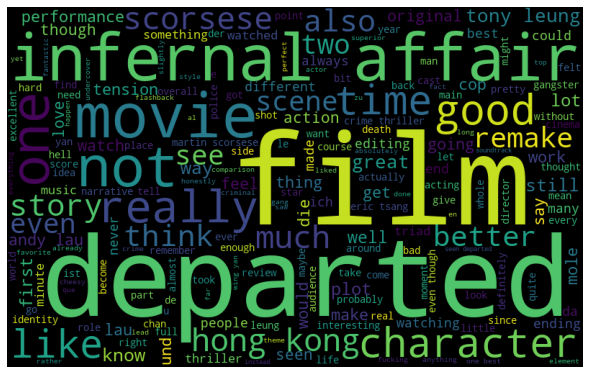

In [ ]:
from wordcloud import WordCloud
words_list = reviews['processed'].unique().tolist()
pos_words = " ".join(words_list)

pos_wordcloud =  WordCloud(
                  width=800, height = 500,
                  stopwords=stop_words).generate(pos_words)

plt.figure(figsize=(8, 8), facecolor = None)
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
test1['word_list'] = test1['review'].apply(data_preprocessing)
test1.head()

<ipython-input-51-8ba017ad3682>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['word_list'] = test1['review'].apply(data_preprocessing)


title  year user_rating watched_date  \
0        The Awful Truth  1937           4  11 Feb 2023   
1            Le Samouraï  1967         4.5  10 Feb 2023   
2               Rashomon  1950           5  10 Feb 2023   
5  The African Desperate  2022         3.5  07 Feb 2023   
6            House Party  1990           4  07 Feb 2023   

                                              review  \
0  idk but i would never let cary grant divorce m...   
1  This review may contain spoilers. I can handle...   
2  BITCH. i get it now. kurosawa i will never dou...   
5  awwh i miss scad kind ofthe anti criterion cha...   
6  can’t stop thinking about “the sign on my ass ...   

                                              tokens  \
0  [idk, would, never, let, cari, grant, divorc, ...   
1  [review, may, contain, spoiler, handl, truth, ...   
2               [bitch, get, kurosawa, never, doubt]   
5  [awwh, miss, scad, kind, ofth, anti, criterion...   
6  [’, stop, think, “, sign, ass, say, ‘, enter, ...   

                                           word_list  
0  idk would never let cary grant divorce like ne...  
1  review may contain spoiler handle truth think ...  
2                     bitch get kurosawa never doubt  
5  awwh miss scad kind ofthe anti criterion chall...  
6  stop thinking sign as say not enter perhaps ne...

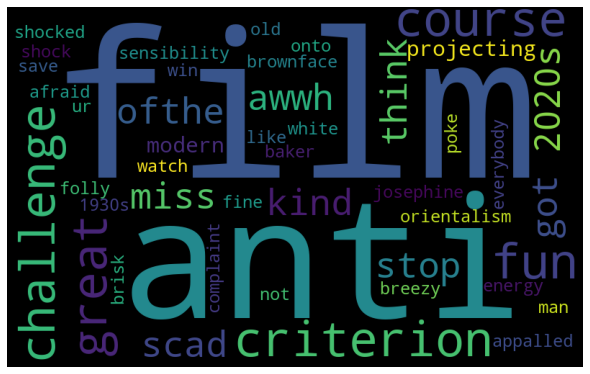

In [ ]:
from wordcloud import WordCloud
words_list = test1[test1['user_rating']=='3.5']['word_list'].unique().tolist()
pos_words = " ".join(words_list)

pos_wordcloud =  WordCloud(
                  width=800, height = 500,
                  stopwords=stop_words).generate(pos_words)

plt.figure(figsize=(8, 8), facecolor = None)
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
X_train = test1.copy()
vect = CountVectorizer(min_df=10)

X_train_review_bow = vect.fit_transform(X_train['word_list'])

print('X_train_review_bow shape: ', X_train_review_bow.shape)

X_train_review_bow shape:  (497, 85)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
X_train_review_tfidf = vectorizer.fit_transform(X_train['word_list'])
print('X_train_review_tfidf shape: ', X_train_review_tfidf.shape)

X_train_review_tfidf shape:  (497, 85)


In [ ]:
from sklearn.model_selection import train_test_split

data = test1.copy()
y = data['user_rating'].values
data.drop(['label'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, stratify=y)

print("Train data:",  X_train.shape, y_train.shape)
print("Test data:",  X_test.shape, y_test.shape)

In [ ]:
X_train['user_rating'].value_counts()

4      213
3.5    142
4.5     71
5       71
Name: user_rating, dtype: int64

In [ ]:
y_train = X_train['user_rating'].replace(['4','4.5','5','3.5'],[1,1,1,0])

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

clf = MultinomialNB()
clf.fit(X_train_review_bow, y_train)

y_pred = clf.predict(X_test_review_bow) #prediction from model
print('Test Accuracy: ', accuracy_score(y_test, y_pred))

In [ ]:
%%time

# this cell may take over a minute to run
import num2words
from num2words import num2words

def process_text(text):
    tokenized = Tokenizer.tokenize(text)
    punctuation = list(string.punctuation)
    #punctuation.remove('!')
    tokenized_no_punctuation=[word.lower() for word in tokenized if word not in punctuation]
    tokenized_no_stopwords=[word for word in tokenized_no_punctuation if word not in stopwords.words('english')]
    tokens = [PorterStemmer().stem(word) for word in tokenized_no_stopwords if word != '️']
    for i in range(len(tokens)):
        try:
            tokens[i]=num2words(tokens[i])
        except:
            pass

    return tokens

# Applies the process_text function separately to each element of the column 'text'
# This is faster than creating a for loop

test1['tokens']=test1['review'].apply(process_text)
test1.head(10)

CPU times: user 2.42 s, sys: 211 ms, total: 2.63 s
Wall time: 2.75 s


<timed exec>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


title  year user_rating watched_date  \
0         The Awful Truth  1937           4  11 Feb 2023   
1             Le Samouraï  1967         4.5  10 Feb 2023   
2                Rashomon  1950           5  10 Feb 2023   
5   The African Desperate  2022         3.5  07 Feb 2023   
6             House Party  1990           4  07 Feb 2023   
8          Stormy Weather  1943           4  05 Feb 2023   
10       Princess Tam Tam  1935         3.5  04 Feb 2023   
12        The Awful Truth  1937           4  11 Feb 2023   
13            Le Samouraï  1967         4.5  10 Feb 2023   
14               Rashomon  1950           5  10 Feb 2023   

                                               review  \
0   idk but i would never let cary grant divorce m...   
1   This review may contain spoilers. I can handle...   
2   BITCH. i get it now. kurosawa i will never dou...   
5   awwh i miss scad kind ofthe anti criterion cha...   
6   can’t stop thinking about “the sign on my ass ...   
8          black history month 20232. a black musical   
10  i just think we’ve got to stop projecting our ...   
12  idk but i would never let cary grant divorce m...   
13  This review may contain spoilers. I can handle...   
14  BITCH. i get it now. kurosawa i will never dou...   

                                               tokens  
0   [idk, would, never, let, cari, grant, divorc, ...  
1   [review, may, contain, spoiler, handl, truth, ...  
2                [bitch, get, kurosawa, never, doubt]  
5   [awwh, miss, scad, kind, ofth, anti, criterion...  
6   [’, stop, think, “, sign, ass, say, ‘, enter, ...  
8   [black, histori, month, twenty thousand, two h...  
10  [think, ’, got, stop, project, modern, sensibl...  
12  [idk, would, never, let, cari, grant, divorc, ...  
13  [review, may, contain, spoiler, handl, truth, ...  
14               [bitch, get, kurosawa, never, doubt]

In [ ]:
fdist = nltk.FreqDist()

# we count the frequency of each word  (feature) in our corpus (dataset)
# for every tweet
for words in test1['tokens']:
     # we go through each word in the host_verification
    for word in words:
        # create a key in our dictionary for that word
        # and increment the count by 1
        # fdist[word]  = fdist[word] +  1
            fdist[word] += 1

print(f'Number of unique tokens: {len(fdist)}')
print('\n')


print('\n words with top 10 frequencies')
words10=pd.DataFrame.from_dict(dict(fdist.most_common()[:10]), \
                               orient='index', columns=['Counts'])
print(words10)

Number of unique tokens: 87



 words with top 10 frequencies
          Counts
’            355
never        284
think        213
black        213
film         213
like         142
challeng     142
stop         142
ass          142
histori      142


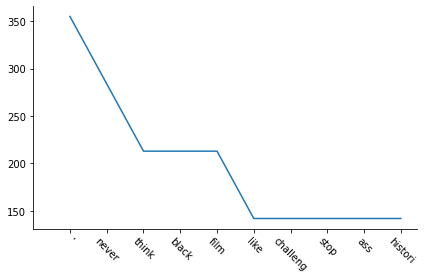

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, ax = plt.subplots()

y = pd.Series(dict(fdist.most_common()[:10]))
y = y.sort_values(ascending=False)

y.plot()

indexes = np.arange(0, len(y)) # we will place ticks for every word
ax.set_xticks(indexes)
ax.set_xticklabels(y.index, rotation='-45')
ax.set_xlim(-1)

plt.tight_layout()

sns.despine()
plt.show()

In [ ]:
film_meta = {'film':[],'meta_data':[]}
for i in title_for_url[0:4]:
  film_meta['film'].append(i)
  film_meta['meta_data'].append(movie_metadata(f'https://letterboxd.com/film/{i}/'))
pd.DataFrame(film_meta)

film                                          meta_data
0     the-awful-truth  {'title': 'The Awful Truth (1937)', 'release y...
1         le-samourai  {'title': 'Le Samouraï (1967)', 'release year'...
2            rashomon  {'title': 'Rashomon (1950)', 'release year': '...
3  the-blood-of-jesus  {'title': 'The Blood of Jesus (1941)', 'releas...

In [ ]:
film_meta = {}
title_num = df1.shape[0]
#pbar = tqdm(range(1, title_num+1))
tbar = tqdm(range(1,5))

for t in tbar:
    tbar.set_description(f"Scraping title {t} of {title_num} of this user's movie")

    for i in title_for_url[0:4]:
      film_meta[i] = movie_metadata(f'https://letterboxd.com/film/{i}/')

film_meta

Scraping title 4 of 852 of this user's movie: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


{'the-awful-truth': {'title': 'The Awful Truth',
  'release year': '1937',
  'director(s)': ['Leo McCarey'],
  'cast': ['Irene Dunne',
   'Cary Grant',
   'Ralph Bellamy',
   "Alexander D'Arcy",
   'Cecil Cunningham',
   'Molly Lamont',
   'Esther Dale',
   'Joyce Compton',
   'Robert Allen',
   'Robert Warwick',
   'Mary Forbes',
   'Claud Allister',
   'Al Bridge',
   'Edgar Dearing',
   'Wyn Cahoon',
   'Sarah Edwards',
   'Bess Flowers',
   'Mitchell Harris',
   'Dell Henderson',
   'Scott Kolk',
   'Bert Moorhouse',
   'Miki Morita',
   'Edmund Mortimer',
   'Zita Moulton',
   'George C. Pearce',
   'Edward Peil Sr.',
   'Paul Stanton',
   'John Tyrrell',
   'Frank C. Wilson',
   'Ruth Cherrington',
   'Dora Clement',
   'Arthur Stuart Hull',
   'Frank McLure',
   'Frances Raymond',
   'Bruce Sidney',
   'Lee Willard',
   'Skippy'],
  'rating': '3.86',
  'genres': ['romance', 'comedy', 'drama'],
  'producer(s)': ['Leo McCarey'],
  'writer(s)': ['Sidney Buchman', 'Viña Delmar'],
  